# Example of using TF-IDF to score rare diagnoses codes

This is an example notebook about how to use the functions in `tf_idf_funcs.py` to encode diagnoses codes for their rarity. It also has code to do one hot encoding taking into account *all* of the diagnoses codes.

[Andy Wheeler, PhD](mailto:andrew.wheeler@hms.com)

In [1]:
#Loading libraries, functions, and data

import pandas as pd
import numpy as np
#logit and random forest models

#######
#importing the functions and objects to change the plot style
import os
my_dir = r'C:\Users\e009156\Documents\GitHub\data-science-utils\fe_DiagCodes'
os.chdir(my_dir)
from tf_idf_funcs import *
#######

#grab the datasets
train_dt = pd.read_csv('Simulated_Train.csv')
test_dt = pd.read_csv('Simulated_Test.csv')

#basic encoding of other variables here??????

train_dt.head()

,Finding,AdmitType,Gender,ProviderNumber,StateID,procCode1,procCode2,procCode3,procCode4,procCode5,...,diagCode20,diagCode21,diagCode22,diagCode23,diagCode24,diagCode25,AdmitDate_dt,TimeIn,Age,Train
0,0,1.0,M,1004573,SC,3E0234Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-09,3.0,45.314168,1
1,0,3.0,F,75074609,PA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-30,3.0,18.644764,1
2,0,1.0,F,F00000000031,MI,0DB68ZX,01B80ZZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-07,2.0,29.837098,1
3,0,1.0,F,60044,PA,B547ZZA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-10,3.0,0.005476,1
4,0,4.0,F,60017,PA,0SRD0J9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-11,3.0,0.010951,1


This section illustrates how to create the document frequency matrix, and then to encode the variables in several different ways.

  - TF-IDF for each diagnoses (done)
  - one-hot encoding for all of the different columns (done)
  - calculating a sum of rare diagnoses (done)
  - prevalence scores for primary vs other diagnoses (done)
  - updating a term matrix for new values/missing data (done)
  - TF-IDF for *pairs* of codes (ToDo)
  
And then give an example of training/testing a model (ToDo

In [2]:
#Estimating the term matrix, this should be pretty memory safe

diags = ['diagCode'+str(i+1) for i in range(25)]
procs = ['procCode'+str(i+1) for i in range(6)]

diag_prev = freq_tab(train_dt, diags)
proc_prev = freq_tab(train_dt, procs)

diag_prev

,Freq,prop,logIDF,const
03819,4.0,0.000015,8.529221,1
0389,1.0,0.000004,9.915515,1
0413,2.0,0.000008,9.222368,1
1361,1.0,0.000004,9.915515,1
27669,1.0,0.000004,9.915515,1
...,...,...,...,...
Z992,428.0,0.001623,3.856392,1
Z993,73.0,0.000277,5.625055,1
Z9981,734.0,0.002783,3.317006,1
Z9989,34.0,0.000129,6.389154,1


C:\Users\e009156\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


   E785_idf  F17210_idf  I10_idf  K219_idf  N179_idf
0  0.000000    1.475851      0.0  0.000000       0.0
1  0.000000    1.475851      0.0  0.000000       0.0
2  1.847425    1.475851      0.0  1.903165       0.0
3  0.000000    1.475851      0.0  0.000000       0.0
4  0.000000    0.000000      0.0  0.000000       0.0
   E785_dum  F17210_dum  I10_dum  K219_dum  N179_dum
0       0.0         1.0      0.0       0.0       0.0
1       0.0         1.0      0.0       0.0       0.0
2       1.0         1.0      0.0       1.0       0.0
3       0.0         1.0      0.0       0.0       0.0
4       0.0         0.0      0.0       0.0       0.0


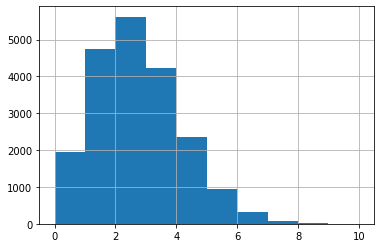

In [4]:
#This function now lets you create new variables for either one hot encoding of the 
#Diagnose code, OR use the prop/logIDF column to encode the variables

#Only limiting to very high N columns to illustrate
#diag_prev.sort_values('Freq')

idf_scores = encode_idf(train_dt, diags, diag_prev, limit=3000, stub='_idf')
one_dummie = encode_idf(train_dt, diags, diag_prev, col_var=3,limit=3000, stub='_dum')

print(idf_scores.head())
print(one_dummie.head())

#You may also use this to calculate up the sum of rare diagnoses codes across the entire set
#default rarity is coded as fewer than 1 in 5000 diagnoses
train_dt['rareSum'] = rare_sum(train_dt, diags, diag_prev)
train_dt['rareSum'].hist()

In [6]:
#One way to encode this in a lower dimension is to just score the rarity of the particular
#primary diagnoses

main_prev = freq_tab(train_dt, ['diagCode1']) #only the primary diagnoses code
rare_code = main_prev.loc[train_dt['diagCode1'],'prop']   #this will give an error for new diagnoses not in the index                                                      
rare_code.index = train_dt.index                          #see the add_indices function to deal with that
train_dt['primRarity'] = rare_code

#You might also look at if one of the alternate codes tends to be a common primary code
#Default missing codes are imputed a particular way to make this work reasonably
for index, rows in train_dt[diags[1:]].iterrows():
    sub = rows[pd.notnull(rows)]
    mx =  max( [0] + list(main_prev.loc[sub,'prop']) )
    train_dt.loc[index, 'offProp'] = mx
#This loop will be more memory safe I think, but may be better to vectorize this

train_dt['ratioPrimOff'] = np.log( train_dt['offProp'] / train_dt['primRarity'] )

train_dt.describe()

,Finding,AdmitType,procCode6,diagCode23,diagCode24,diagCode25,TimeIn,Age,Train,rareSum,primRarity,offProp,ratioPrimOff
count,20242.000000,20242.000000,0.0,0.0,0.0,0.0,20242.000000,20242.000000,20242.0,20242.000000,20242.000000,20242.000000,20242.000000
mean,0.208379,1.551872,NaN,NaN,NaN,NaN,4.206995,40.395870,1.0,2.241972,0.003771,0.013215,2.143721
std,0.406159,0.943386,NaN,NaN,NaN,NaN,3.905564,18.658558,0.0,1.429654,0.004521,0.004092,1.660798
min,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1.0,0.000000,0.000049,0.000741,-2.254058
25%,0.000000,1.000000,NaN,NaN,NaN,NaN,2.000000,28.285421,1.0,1.000000,0.000445,0.010523,0.806648
50%,0.000000,1.000000,NaN,NaN,NaN,NaN,3.000000,44.076660,1.0,2.000000,0.001680,0.012400,1.972757
75%,0.000000,2.000000,NaN,NaN,NaN,NaN,5.000000,55.923340,1.0,3.000000,0.005385,0.016698,3.338139
max,1.000000,9.000000,NaN,NaN,NaN,NaN,370.000000,95.526352,1.0,10.000000,0.017884,0.017884,5.891644


In [7]:
#This should add a row for when no code is filled out
empty_str = train_dt[diags].fillna('?')
add_indices(diag_prev, empty_str).tail()

#You have a decision to make if you have a ton of new codes - are you going to rescore the data
#Or are you going to just do some type of missing data imputation

        

,Freq,prop,logIDF,const
Z993,73.0,0.000277,5.625055,1
Z9981,734.0,0.002783,3.317006,1
Z9989,34.0,0.000129,6.389154,1
NaN,0.0,0.000000,-1.000000,1
?,0.0,0.000000,-1.000000,1


In [8]:
#Sometimes we want to look at the rarity of a particular code-pair
#Not just an individual code, will illustrate 

test_sub = train_dt[procs+diags].head(10)
test_sub.loc[pd.isnull(test_sub['procCode1']),'procCode1'] = '_' 
#recoding just the first proc code, so shows when there are 0 total proc codes

#within diagnoses codes
#get the inner list of not missing
#do all 2 combinations, put lower code (in string sort order)
#on the left

#pairing diagnoses/procedure
pairs = []
for index, row in test_sub.iterrows():
    pcode = row[procs]
    pcode = pcode[pd.notnull(pcode)].tolist()
    dcode = row[diags]
    dcode = dcode[pd.notnull(dcode)].tolist()
    all_pd = [i + "," + j for i in pcode for j in dcode]
    pairs.append(all_pd)

pair_data = pd.DataFrame(pairs)   
pair_data
#need to rename the columns
#Then you cand do the same frequency table with pairs of codes
    
#test_sub['pd_pairs'] = pairs
#test_sub

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,"3E0234Z,H5350","3E0234Z,K3184","3E0234Z,Z881","3E0234Z,I4892","3E0234Z,E669","3E0234Z,Z811","3E0234Z,P9683","3E0234Z,Z8739","3E0234Z,K210","3E0234Z,D696",...,None,None,None,None,None,None,None,None,None,None
1,"_,I130","_,G40909","_,F251","_,Z7901","_,J9601","_,J441","_,F17210","_,R6520","_,Q935","_,Z79899",...,None,None,None,None,None,None,None,None,None,None
2,"0DB68ZX,R569","0DB68ZX,R319","0DB68ZX,P000","0DB68ZX,I5020","0DB68ZX,K219","0DB68ZX,E785","0DB68ZX,H538","0DB68ZX,Z9114","0DB68ZX,I081","0DB68ZX,A419",...,"01B80ZZ,E785","01B80ZZ,H538","01B80ZZ,Z9114","01B80ZZ,I081","01B80ZZ,A419","01B80ZZ,E871","01B80ZZ,J9621","01B80ZZ,F17210",None,None
3,"B547ZZA,Z9221","B547ZZA,I959","B547ZZA,E0590","B547ZZA,I1311","B547ZZA,O9822","B547ZZA,E1165","B547ZZA,E43","B547ZZA,I5021","B547ZZA,I9589","B547ZZA,D62",...,None,None,None,None,None,None,None,None,None,None
4,"0SRD0J9,T401X1A","0SRD0J9,Z888","0SRD0J9,Z7984","0SRD0J9,E1065","0SRD0J9,Z66","0SRD0J9,Z98891","0SRD0J9,Z6842","0SRD0J9,T827XXA","0SRD0J9,Z923","0SRD0J9,B182",...,None,None,None,None,None,None,None,None,None,None
5,"0VTTXZZ,E785","0VTTXZZ,K5900","0VTTXZZ,K219","0VTTXZZ,O99214","0VTTXZZ,R918","0VTTXZZ,S39011A","0VTTXZZ,Z87891","0VTTXZZ,P221","0VTTXZZ,I110","0VTTXZZ,M6008",...,"3E033VJ,R918","3E033VJ,S39011A","3E033VJ,Z87891","3E033VJ,P221","3E033VJ,I110","3E033VJ,M6008","3E033VJ,O701","3E033VJ,O99344","3E033VJ,E441","3E033VJ,M609"
6,"_,A419","_,P9689","_,E6601","_,R7881","_,I129","_,D630","_,N179","_,O9903","_,Z79899","_,Z7982",...,None,None,None,None,None,None,None,None,None,None
7,"_,F259","_,K8590","_,R197","_,F17210","_,B9620","_,R159","_,Z823","_,Z3801","_,O365931","_,Z888",...,None,None,None,None,None,None,None,None,None,None
8,"_,Z370","_,F410","_,N182","_,R701","_,F17210","_,G8929","_,M5416","_,J9600","_,J45909","_,R599",...,None,None,None,None,None,None,None,None,None,None
9,"_,J811","_,F17210","_,K219","_,F329","_,R748","_,E876","_,Z370","_,F1010","_,J13","_,I878",...,None,None,None,None,None,None,None,None,None,None


In [ ]:
#showing how to use this in a ml pipeline with k-fold cross-validation 
#and applying to a new dataset
